<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/timeseries/ml/cnn_tcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [82]:
import kagglehub

path = kagglehub.dataset_download("abhisheksjha/time-series-air-quality-data-of-india-2010-2023")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'time-series-air-quality-data-of-india-2010-2023' dataset.
Path to dataset files: /kaggle/input/time-series-air-quality-data-of-india-2010-2023


In [83]:
path += "/AP001.csv"

In [84]:
aq_dataset = pd.read_csv(path, parse_dates=["From Date", "To Date"], index_col='From Date')

In [85]:
aq_dataset.head()

,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C)
From Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 10:00:00,2016-07-01 11:00:00,10.67,39.0,17.67,39.2,32.33,7.07,6.60,0.48,14.5,...,33.43,71.67,2.30,226.33,123.67,NaN,-0.1,0.1,0.0,23.05
2016-07-01 11:00:00,2016-07-01 12:00:00,2.00,39.0,20.50,41.9,35.80,7.40,NaN,0.49,15.0,...,33.70,70.00,2.50,223.00,186.00,NaN,-0.1,0.1,0.0,NaN
2016-07-01 12:00:00,2016-07-01 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 13:00:00,2016-07-01 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 14:00:00,2016-07-01 15:00:00,20.50,50.0,15.40,43.6,32.78,6.35,6.38,0.47,10.5,...,33.57,63.50,1.88,223.00,240.50,NaN,-0.1,0.1,0.0,NaN


In [86]:
aq_dataset.columns

Index(['To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
       'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
       'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'SR (W/mt2)',
       'BP (mmHg)', 'VWS (m/s)', 'Xylene (ug/m3)', 'RF (mm)', 'AT (degree C)'],
      dtype='object')

<Axes: xlabel='From Date'>

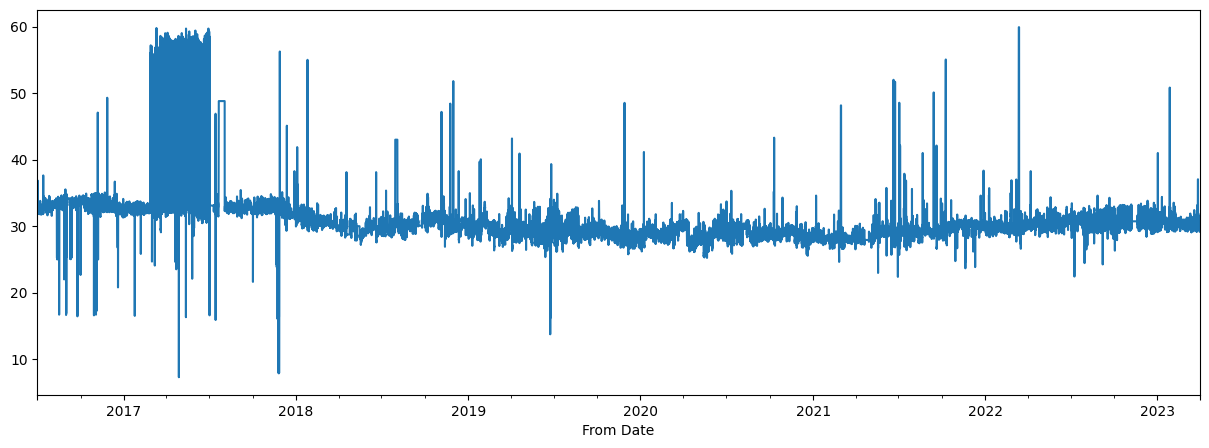

In [87]:
aq_dataset['Temp (degree C)'].ffill().plot(figsize=(15, 5))

In [88]:
# Load and preprocess data
aq_dataset = pd.read_csv(path, parse_dates=["From Date", "To Date"], index_col='From Date')
ts = aq_dataset['Temp (degree C)'].ffill().values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)

# Parameters
seq_length = 7
train_size = int(len(ts_scaled) * 0.8)
train_data = ts_scaled[:train_size]
test_data = ts_scaled[train_size:]

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


#### CNN

In [89]:
# CNN Model
class CNNForecast(nn.Module):
    def __init__(self):
        super(CNNForecast, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)  # Added pooling to reduce dimensionality
        self.fc = nn.Linear(64 * (seq_length // 2), 1)  # Adjust based on pooling

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, seq_len, 1) → (batch, 1, seq_len)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)  # Reduce temporal dimension
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNForecast().to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNForecast().to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


In [91]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}')

Epoch 50/1000, Loss: 0.002670
Epoch 100/1000, Loss: 0.002020
Epoch 150/1000, Loss: 0.001933
Epoch 200/1000, Loss: 0.001894
Epoch 250/1000, Loss: 0.001867
Epoch 300/1000, Loss: 0.001840
Epoch 350/1000, Loss: 0.001802
Epoch 400/1000, Loss: 0.001781
Epoch 450/1000, Loss: 0.001768
Epoch 500/1000, Loss: 0.001759
Epoch 550/1000, Loss: 0.001754
Epoch 600/1000, Loss: 0.001750
Epoch 650/1000, Loss: 0.001747
Epoch 700/1000, Loss: 0.001745
Epoch 750/1000, Loss: 0.001742
Epoch 800/1000, Loss: 0.001739
Epoch 850/1000, Loss: 0.001737
Epoch 900/1000, Loss: 0.001735
Epoch 950/1000, Loss: 0.001732
Epoch 1000/1000, Loss: 0.001730


In [92]:
# Predictions
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).cpu().numpy()
    y_pred_test = model(X_test).cpu().numpy()

# Inverse transform
y_train_inv = scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))
y_pred_train_inv = scaler.inverse_transform(y_pred_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

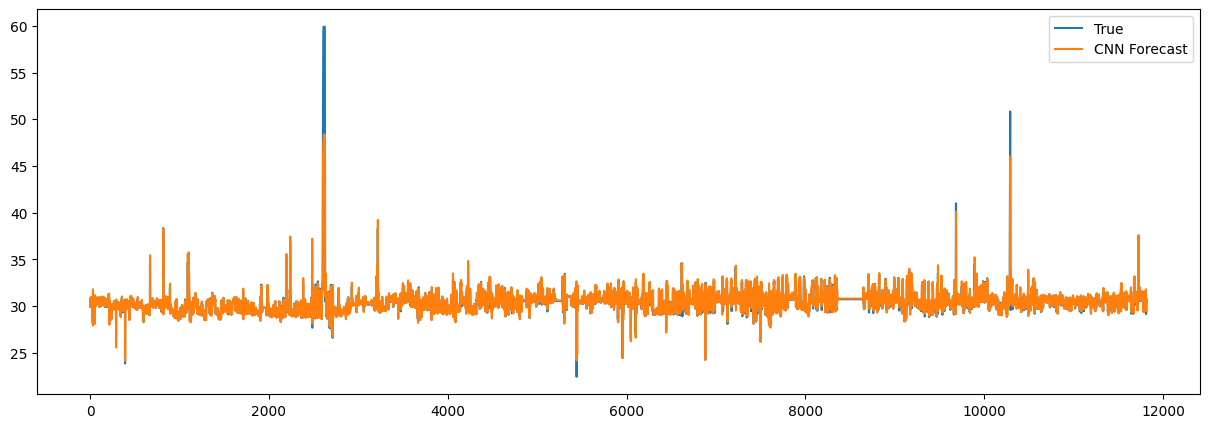

In [93]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label="True")
plt.plot(y_pred_test_inv, label="CNN Forecast")
plt.legend()
plt.show()


In [94]:
# Metrics
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
mse = mean_squared_error(y_test_inv, y_pred_test_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_test_inv)

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Value': [mae, mse, rmse, r2]
})
print(metrics_df)

  Metric     Value
0    MAE  0.295056
1    MSE  0.522317
2   RMSE  0.722715
3     R²  0.793910


#### TCN

In [95]:
ts = aq_dataset['Temp (degree C)'].ffill().values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)

# Parameters
seq_length = 7
train_size = int(len(ts_scaled) * 0.7)  # 70% train
val_size = int(len(ts_scaled) * 0.1)   # 10% validation
test_size = len(ts_scaled) - train_size - val_size

train_data = ts_scaled[:train_size]
val_data = ts_scaled[train_size:train_size + val_size]
test_data = ts_scaled[train_size + val_size:]

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [96]:
# TCN Block
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TCNBlock, self).__init__()
        # Calculate padding to maintain sequence length
        padding = (dilation * (kernel_size - 1)) // 2
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.residual = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = self.relu(out)
        res = self.residual(x)
        # Verify shapes before addition
        assert out.size(2) == res.size(2), f"Shape mismatch: out={out.size(2)}, res={res.size(2)}"
        return out + res  # Residual connection

# TCN Model
class TCNForecast(nn.Module):
    def __init__(self, in_channels=1, seq_length=7, num_channels=[32, 64], kernel_size=3):
        super(TCNForecast, self).__init__()
        layers = []
        for i, channels in enumerate(num_channels):
            dilation = 2 ** i  # Exponential dilation
            layers.append(TCNBlock(in_channels if i == 0 else num_channels[i-1],
                                  channels, kernel_size, dilation))
        self.tcn = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, seq_len, 1) → (batch, 1, seq_len)
        x = self.tcn(x)          # Apply TCN blocks
        x = self.pool(x)         # (batch, channels, 1)
        x = x.squeeze(-1)        # (batch, channels)
        x = self.fc(x)           # (batch, 1)
        return x


In [101]:


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCNForecast(seq_length=seq_length).to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Training with early stopping
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000
patience = 20

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val)
        val_loss = criterion(y_pred_val, y_val)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss.item():.6f}, Val Loss: {val_loss.item():.6f}')


Epoch 50/1000, Train Loss: 0.002129, Val Loss: 0.001755
Epoch 100/1000, Train Loss: 0.002017, Val Loss: 0.000368
Epoch 150/1000, Train Loss: 0.001978, Val Loss: 0.000340
Epoch 200/1000, Train Loss: 0.001953, Val Loss: 0.000329
Epoch 250/1000, Train Loss: 0.001935, Val Loss: 0.000313
Epoch 300/1000, Train Loss: 0.001921, Val Loss: 0.000306
Epoch 350/1000, Train Loss: 0.001911, Val Loss: 0.000294
Epoch 400/1000, Train Loss: 0.001902, Val Loss: 0.000290
Epoch 450/1000, Train Loss: 0.001894, Val Loss: 0.000288
Epoch 500/1000, Train Loss: 0.001888, Val Loss: 0.000280
Epoch 550/1000, Train Loss: 0.001883, Val Loss: 0.000271
Epoch 600/1000, Train Loss: 0.001878, Val Loss: 0.000267
Epoch 650/1000, Train Loss: 0.001874, Val Loss: 0.000266
Epoch 700/1000, Train Loss: 0.001870, Val Loss: 0.000263
Epoch 750/1000, Train Loss: 0.001866, Val Loss: 0.000263
Epoch 800/1000, Train Loss: 0.001863, Val Loss: 0.000261
Epoch 850/1000, Train Loss: 0.001859, Val Loss: 0.000272
Epoch 900/1000, Train Loss: 0.00

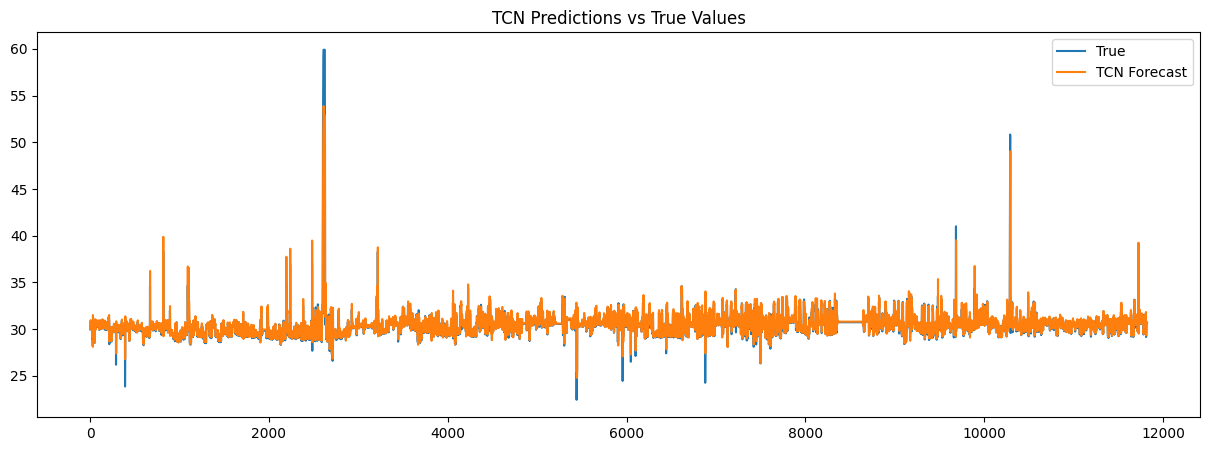

  Metric     Value
0    MAE  0.303571
1    MSE  0.427688
2   RMSE  0.653978
3     R²  0.831248


In [102]:


# Predictions
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).cpu().numpy()
    y_pred_val = model(X_val).cpu().numpy()
    y_pred_test = model(X_test).cpu().numpy()

# Inverse transform
y_train_inv = scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))
y_pred_train_inv = scaler.inverse_transform(y_pred_train.reshape(-1, 1))
y_val_inv = scaler.inverse_transform(y_val.cpu().numpy().reshape(-1, 1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Plot
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label="True")
plt.plot(y_pred_test_inv, label="TCN Forecast")
plt.legend()
plt.title("TCN Predictions vs True Values")
plt.show()

# Metrics
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
mse = mean_squared_error(y_test_inv, y_pred_test_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_test_inv)

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Value': [mae, mse, rmse, r2]
})
print(metrics_df)